## Topic classification using BoW Embeddings

In [15]:
import pandas as pd
df_cleaned = pd.read_csv("../data/cleaned_merged_all_articles.csv", index_col=0).drop(columns=['title', 'representative_name', 'representative_state', 'representative_party', 'representative_committee', 'date'])
df_single_issue = df_cleaned[~df_cleaned['issue'].str.contains(';')]
selected_issues = [
    "Energy and Environment", "Education", "Health Care and Social Security", "Jobs and the Economy",
				"National Security, Defence, Foreign Affairs", "Veterans and Military"
  ]
df = df_single_issue[df_single_issue['issue'].isin(selected_issues)]
df.groupby("issue")["text"].count()

issue
Education                                      1411
Energy and Environment                         2380
Health Care and Social Security                2930
Jobs and the Economy                           2333
National Security, Defence, Foreign Affairs    3673
Veterans and Military                          1376
Name: text, dtype: int64

In [ ]:
import re
import nltk
from nltk.stem import WordNetLemmatizer

stop_words_path = "../SmartStoplist.txt"
lemmatizer = WordNetLemmatizer()

def load_stop_words():
    stop_words = []
    with open(stop_words_path, "r") as f:
        stop_words = f.read().split("\n")
    return set(stop_words)

def preprocess_text(text: str, stopwords) -> str:
    text = re.sub(r"http\S+", "", text) # remove links
    text = re.sub("[^A-Za-z]+", " ", text) # remove special characters and numbers
    tokens = nltk.word_tokenize(text.lower()) # tokenization
    tokens = [w for w in tokens if not w in stopwords] # remove stop words
    tokens = [lemmatizer.lemmatize(w) for w in tokens] # remove stop words + lemmatization
    text = " ".join(tokens)
    text = text.lower().strip()
    return text


stopwords = load_stop_words()
df.loc[:, "text"] = df["text"].apply(lambda text: preprocess_text(text, stopwords))
df = df[df["text"] != ""]

In [3]:
most_common_words=[
    'state', 'act', 'community', 'federal', 'year', 'american', 'rep', 'house', 'congressman', 'program', 'today', 'service', 'support', 'member', 'committee'
]

CountVectorizer creates a Bag of Words representation of the text data.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch import nn
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['issue'])

# Split the dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# Initialize CountVectorizer for BoW
vectorizer = CountVectorizer(ngram_range=(1,4), stop_words=most_common_words, min_df=100)
train_embeddings = vectorizer.fit_transform(train_texts.tolist()).toarray()
val_embeddings = vectorizer.transform(val_texts.tolist()).toarray()

# Convert to tensors
train_embeddings_tensor = torch.tensor(train_embeddings, dtype=torch.float32)
val_embeddings_tensor = torch.tensor(val_embeddings, dtype=torch.float32)

train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)

# Create datasets
train_dataset = TensorDataset(train_embeddings_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_embeddings_tensor, val_labels_tensor)

# Data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

Troubles with Count vectorizer:
```
Unable to allocate 404. GiB for an array with shape (11282, 4805714) and data type int64
```

In [5]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, model, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            torch.save(model.state_dict(), 'checkpoint.pt')
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


class SimpleNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.fc(x)


def train(classifier, criterion, optimizer, train_loader, val_loader, epochs=30, patience=3, min_delta=10):
	if patience is None or min_delta is None:
		early_stopper = lambda x: False
	else:
		early_stopper = EarlyStopper(patience=patience, min_delta=min_delta)

	losses = []
	val_losses = []
	for epoch in range(epochs):  # Train for 10 epochs
					classifier.train()
					for batch in train_loader:
									optimizer.zero_grad()

									embeddings, labels = batch
									embeddings = embeddings.to(device)
									labels = labels.to(device).long()

									outputs = classifier(embeddings)
									loss = criterion(outputs, labels)
									loss.backward()
									optimizer.step()
									

					final_loss = loss.item()
					classifier.eval()
					with torch.no_grad():
						for batch in val_loader:
							embeddings, labels = batch
							embeddings = embeddings.to(device)
							labels = labels.to(device).long()

							outputs = classifier(embeddings)
							val_loss = criterion(outputs, labels).item()
					print(f"Epoch {epoch + 1}, Loss: {final_loss}, Val loss: {val_loss}")
					losses.append(final_loss)
					val_losses.append(val_loss)
					if early_stopper.early_stop(classifier, val_loss):
						break
  
	if patience is not None and min_delta is not None:
		classifier.load_state_dict(torch.load('checkpoint.pt', weights_only=True))

	return losses, val_losses

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [7]:
def evaluate(classifier, val_loader):
	classifier.eval()
	all_predictions = []
	all_labels = []
	with torch.no_grad():
					for batch in val_loader:
									embeddings, labels = batch
									embeddings = embeddings.to(device)
									labels = labels.to(device).long()

									outputs = classifier(embeddings)
									predictions = torch.argmax(outputs, dim=-1)

									all_predictions.extend(predictions.cpu().numpy())
									all_labels.extend(labels.cpu().numpy())

	# Generate classification report
	print(classification_report(all_labels, all_predictions, target_names=label_encoder.classes_))

	# Generate confusion matrix
	cm = confusion_matrix(all_labels, all_predictions)
	cm_display_labels = label_encoder.classes_

	# Plot confusion matrix
	plt.figure(figsize=(10, 8))
	sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_display_labels, yticklabels=cm_display_labels)
	plt.xlabel('Predicted Label')
	plt.ylabel('True Label')
	plt.title('Confusion Matrix')
	plt.show()

In [8]:
model_simple = SimpleNN(input_dim=train_embeddings_tensor.size(1), num_classes=len(df['issue'].unique()))
model_simple.to(device)

criterion_cros_entr_loss = nn.CrossEntropyLoss()
optimizer_adam = torch.optim.Adam(model_simple.parameters(), lr=5e-5, weight_decay=1e-6)
losses, val_losses = train(model_simple, criterion_cros_entr_loss, optimizer_adam, train_loader, val_loader, 500, patience=3, min_delta=2)

Epoch 1, Loss: 1.8966771364212036, Val loss: 1.0896670818328857
Epoch 2, Loss: 1.24272620677948, Val loss: 0.7902339696884155
Epoch 3, Loss: 0.8295527100563049, Val loss: 0.6391658782958984
Epoch 4, Loss: 1.3823789358139038, Val loss: 0.5701498985290527
Epoch 5, Loss: 0.7393693327903748, Val loss: 0.5396150350570679
Epoch 6, Loss: 0.6136200428009033, Val loss: 0.5109347701072693
Epoch 7, Loss: 0.8340985178947449, Val loss: 0.5320905447006226
Epoch 8, Loss: 0.885510265827179, Val loss: 0.5967453718185425
Epoch 9, Loss: 0.5876517295837402, Val loss: 0.6105119585990906
Epoch 10, Loss: 0.49678173661231995, Val loss: 0.6580937504768372
Epoch 11, Loss: 0.33050915598869324, Val loss: 0.6388832926750183
Epoch 12, Loss: 0.23670335114002228, Val loss: 0.7107301354408264
Epoch 13, Loss: 0.5017451047897339, Val loss: 0.7286806106567383
Epoch 14, Loss: 0.21439315378665924, Val loss: 0.7626491189002991
Epoch 15, Loss: 0.19633810222148895, Val loss: 0.837246298789978
Epoch 16, Loss: 0.338127046823501

                                             precision    recall  f1-score   support

             2nd Amendment and Gun Violence       0.84      0.80      0.82        61
                                Agriculture       0.87      0.80      0.83       152
                                  Education       0.84      0.90      0.87       282
                     Energy and Environment       0.83      0.87      0.85       476
                  Equality and Civil Rights       0.86      0.62      0.72       102
                   Federal Budget and Taxes       0.77      0.55      0.64       133
                         Government and Law       0.77      0.58      0.66       203
            Health Care and Social Security       0.90      0.90      0.90       586
          Infrastructure and Transportation       0.81      0.73      0.77       165
                       Jobs and the Economy       0.69      0.75      0.72       467
                               Local issues       0.78      0.69

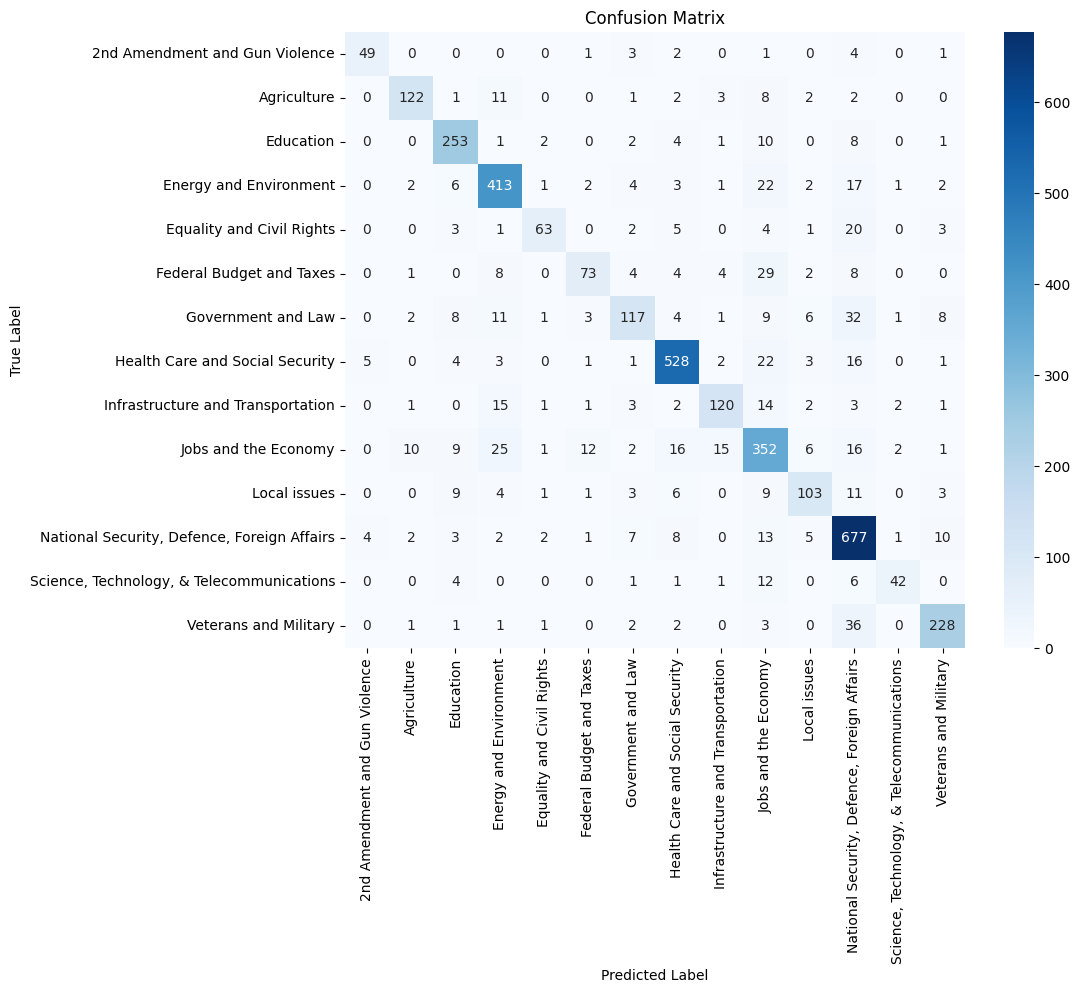

In [9]:
evaluate(model_simple, val_loader)

In [14]:
import matplotlib.pyplot as plt

def plot_training(losses, val_losses, start_epoch = 0, end_epoch=-1):
	plt.figure(figsize=(8, 6))
	plt.plot(list(range(1, len(losses[start_epoch:end_epoch])+1)), losses[start_epoch:end_epoch], marker='o', linestyle='-', color='r', label='Train Loss')
	plt.plot(list(range(1, len(val_losses[start_epoch:end_epoch])+1)), val_losses[start_epoch:end_epoch], marker='o', linestyle='-', color='b', label='Validation Loss')

	# Add labels and title
	plt.xlabel('Epoch')
	plt.ylabel('Training loss')
	plt.title('Training and validation loss (1st model)')
	plt.legend()

	# Show the plot
	plt.grid()
	plt.show()

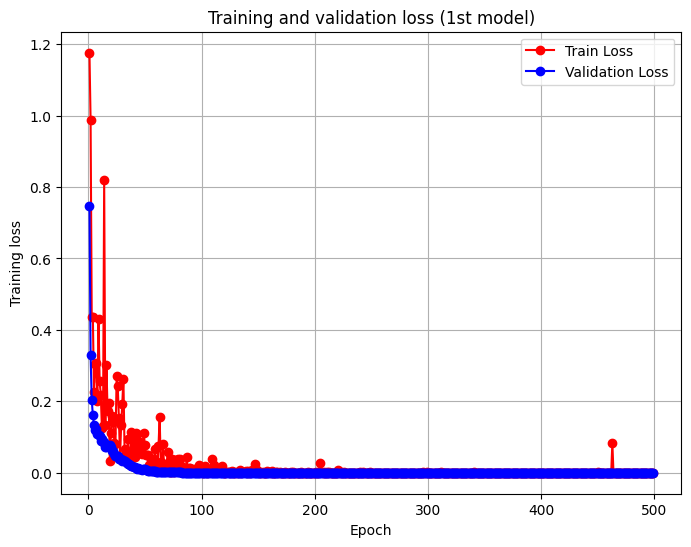

In [16]:
plot_training(losses, val_losses)

---

## Slightly more difficult model

In [10]:
class SlightlyMoreDifficultNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SlightlyMoreDifficultNN, self).__init__()
        self.fc = nn.Sequential(
								nn.Linear(input_dim, 256),
								nn.ReLU(),
								nn.Dropout(0.4),
								nn.Linear(256, 128),
								nn.ReLU(),
								nn.Dropout(0.3),
								nn.Linear(128, num_classes)
							)

    def forward(self, x):
        return self.fc(x)

In [11]:
model_more_diff = SlightlyMoreDifficultNN(input_dim=train_embeddings_tensor.size(1), num_classes=len(df['issue'].unique()))
model_more_diff.to(device)

optimizer_adam_diff = torch.optim.Adam(model_more_diff.parameters(), lr=5e-5, weight_decay=1e-6)
losses, val_losses = train(model_more_diff, criterion_cros_entr_loss, optimizer_adam_diff, train_loader, val_loader, 300, patience=3, min_delta=2)

Epoch 1, Loss: 1.2796236276626587, Val loss: 1.0512405633926392
Epoch 2, Loss: 1.2990156412124634, Val loss: 0.7203648686408997
Epoch 3, Loss: 1.3178602457046509, Val loss: 0.5859986543655396
Epoch 4, Loss: 0.8742203116416931, Val loss: 0.6155816912651062
Epoch 5, Loss: 0.7493608593940735, Val loss: 0.5991169214248657
Epoch 6, Loss: 0.6283937096595764, Val loss: 0.6957567930221558
Epoch 7, Loss: 0.5309841632843018, Val loss: 0.7693592309951782
Epoch 8, Loss: 0.42117583751678467, Val loss: 0.8898665308952332
Epoch 9, Loss: 0.5841076970100403, Val loss: 0.8933213949203491
Epoch 10, Loss: 0.4618700444698334, Val loss: 1.0665241479873657
Epoch 11, Loss: 0.8085305690765381, Val loss: 1.0611838102340698
Epoch 12, Loss: 0.6120913624763489, Val loss: 1.1602075099945068
Epoch 13, Loss: 0.1786465048789978, Val loss: 1.1389957666397095
Epoch 14, Loss: 0.33381152153015137, Val loss: 1.3026485443115234
Epoch 15, Loss: 0.2972409427165985, Val loss: 1.2268918752670288
Epoch 16, Loss: 0.25576391816139

                                             precision    recall  f1-score   support

             2nd Amendment and Gun Violence       0.83      0.72      0.77        61
                                Agriculture       0.87      0.78      0.82       152
                                  Education       0.80      0.89      0.85       282
                     Energy and Environment       0.80      0.87      0.83       476
                  Equality and Civil Rights       0.96      0.46      0.62       102
                   Federal Budget and Taxes       0.80      0.24      0.37       133
                         Government and Law       0.72      0.45      0.56       203
            Health Care and Social Security       0.87      0.91      0.89       586
          Infrastructure and Transportation       0.77      0.59      0.67       165
                       Jobs and the Economy       0.63      0.78      0.70       467
                               Local issues       0.83      0.47

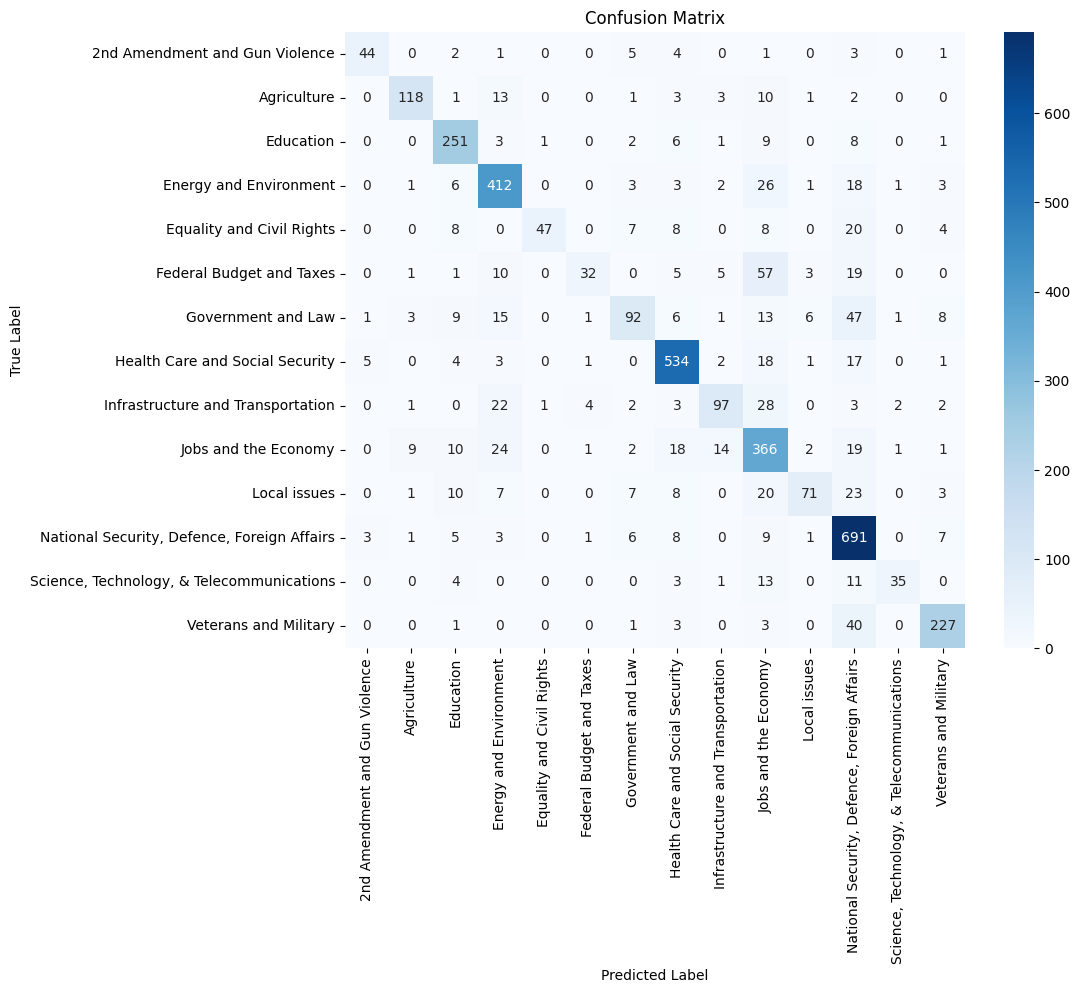

In [12]:
evaluate(model_more_diff, val_loader)

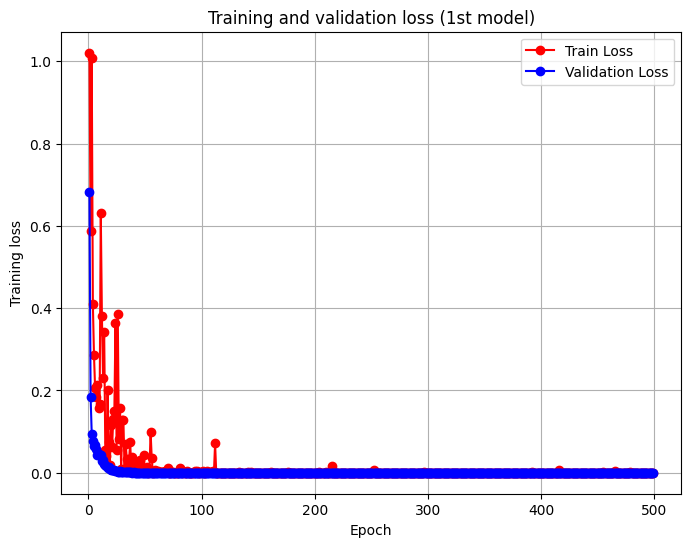

In [30]:
plot_training(losses, val_losses)

----

In [32]:
class SimpleNN2(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleNN2, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

In [34]:
model = SimpleNN2(input_dim=train_embeddings_tensor.size(1), num_classes=len(df['issue'].unique()))
model.to(device)

optimizer_adam = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-6)
losses, val_losses = train(model, criterion_cros_entr_loss, optimizer_adam, train_loader, val_loader, 500, patience=3, min_delta=2)

Epoch 1, Loss: 1.5013020038604736, Val loss: 1.372208833694458
Epoch 2, Loss: 1.176231026649475, Val loss: 0.5370429158210754
Epoch 3, Loss: 0.6659669280052185, Val loss: 0.27179116010665894
Epoch 4, Loss: 0.9891300201416016, Val loss: 0.17409078776836395
Epoch 5, Loss: 0.4288425147533417, Val loss: 0.11781631410121918
Epoch 6, Loss: 0.2916196584701538, Val loss: 0.09169688820838928
Epoch 7, Loss: 0.5050843358039856, Val loss: 0.0723748430609703
Epoch 8, Loss: 0.3579453229904175, Val loss: 0.06257840245962143
Epoch 9, Loss: 0.09827151894569397, Val loss: 0.05383402109146118
Epoch 10, Loss: 0.6169055104255676, Val loss: 0.05008717626333237
Epoch 11, Loss: 0.3207534849643707, Val loss: 0.04420708492398262
Epoch 12, Loss: 0.44821420311927795, Val loss: 0.04536589980125427
Epoch 13, Loss: 0.1873878836631775, Val loss: 0.03911592811346054
Epoch 14, Loss: 0.41126611828804016, Val loss: 0.03166981786489487
Epoch 15, Loss: 0.6556299328804016, Val loss: 0.03247169032692909
Epoch 16, Loss: 0.409

                                             precision    recall  f1-score   support

                                  Education       0.87      0.87      0.87       282
                     Energy and Environment       0.91      0.91      0.91       476
            Health Care and Social Security       0.89      0.92      0.90       586
                       Jobs and the Economy       0.83      0.82      0.83       467
National Security, Defence, Foreign Affairs       0.90      0.92      0.91       735
                      Veterans and Military       0.88      0.82      0.85       275

                                   accuracy                           0.89      2821
                                  macro avg       0.88      0.88      0.88      2821
                               weighted avg       0.89      0.89      0.89      2821



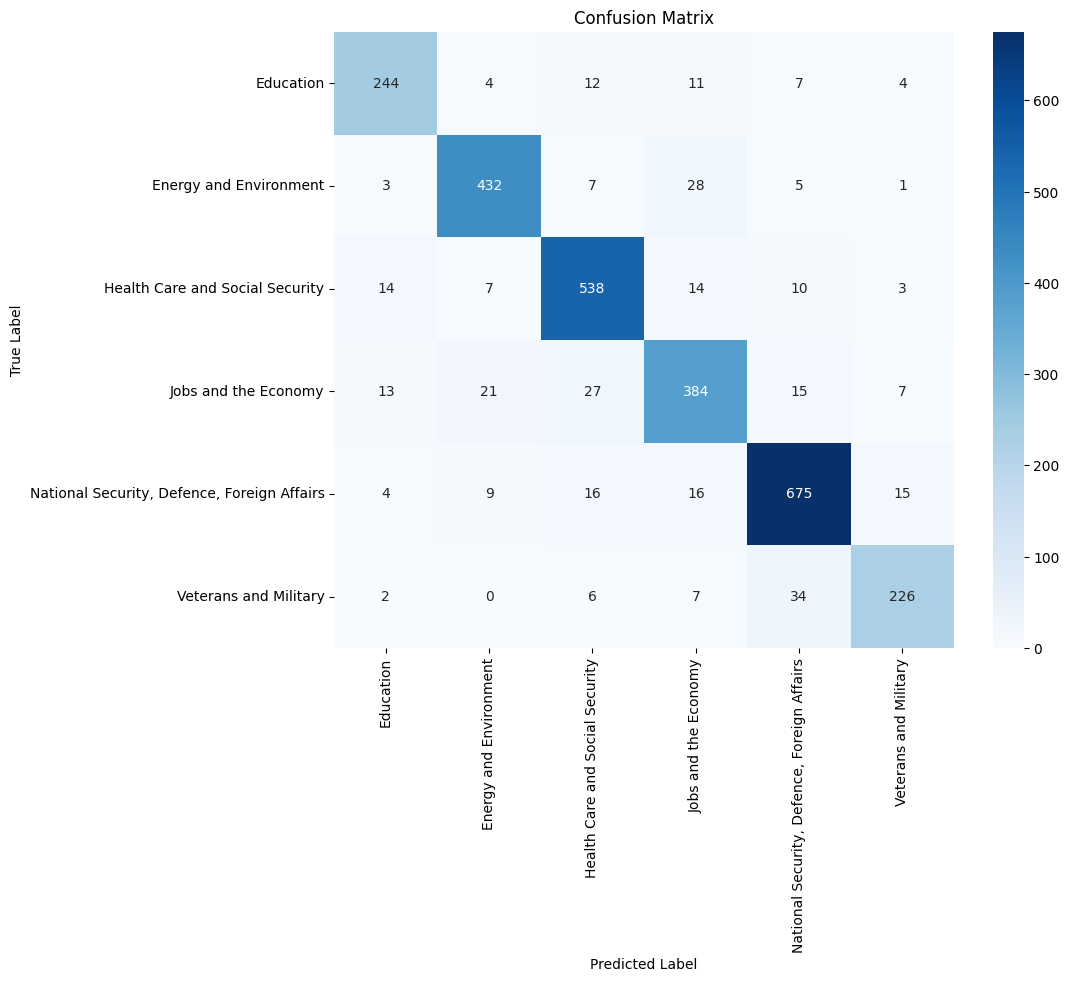

In [35]:
evaluate(model, val_loader)

---

In [13]:
class SimpleNN3(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleNN3, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

In [14]:
model = SimpleNN3(input_dim=train_embeddings_tensor.size(1), num_classes=len(df['issue'].unique()))
model.to(device)

optimizer_adam = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-6)
losses, val_losses = train(model, criterion_cros_entr_loss, optimizer_adam, train_loader, val_loader, 500, patience=3, min_delta=2)

Epoch 1, Loss: 2.4359538555145264, Val loss: 2.2195372581481934


KeyboardInterrupt: 

/home/paulina/usa_issues_data_mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/paulina/usa_issues_data_mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/paulina/usa_issues_data_mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

                                             precision    recall  f1-score   support

             2nd Amendment and Gun Violence       0.88      0.49      0.63        61
                                Agriculture       0.68      0.80      0.73       152
                                  Education       0.79      0.87      0.83       282
                     Energy and Environment       0.78      0.89      0.83       476
                  Equality and Civil Rights       0.83      0.05      0.09       102
                   Federal Budget and Taxes       0.00      0.00      0.00       133
                         Government and Law       0.54      0.37      0.44       203
            Health Care and Social Security       0.90      0.89      0.90       586
          Infrastructure and Transportation       0.65      0.69      0.67       165
                       Jobs and the Economy       0.59      0.76      0.67       467
                               Local issues       0.58      0.57

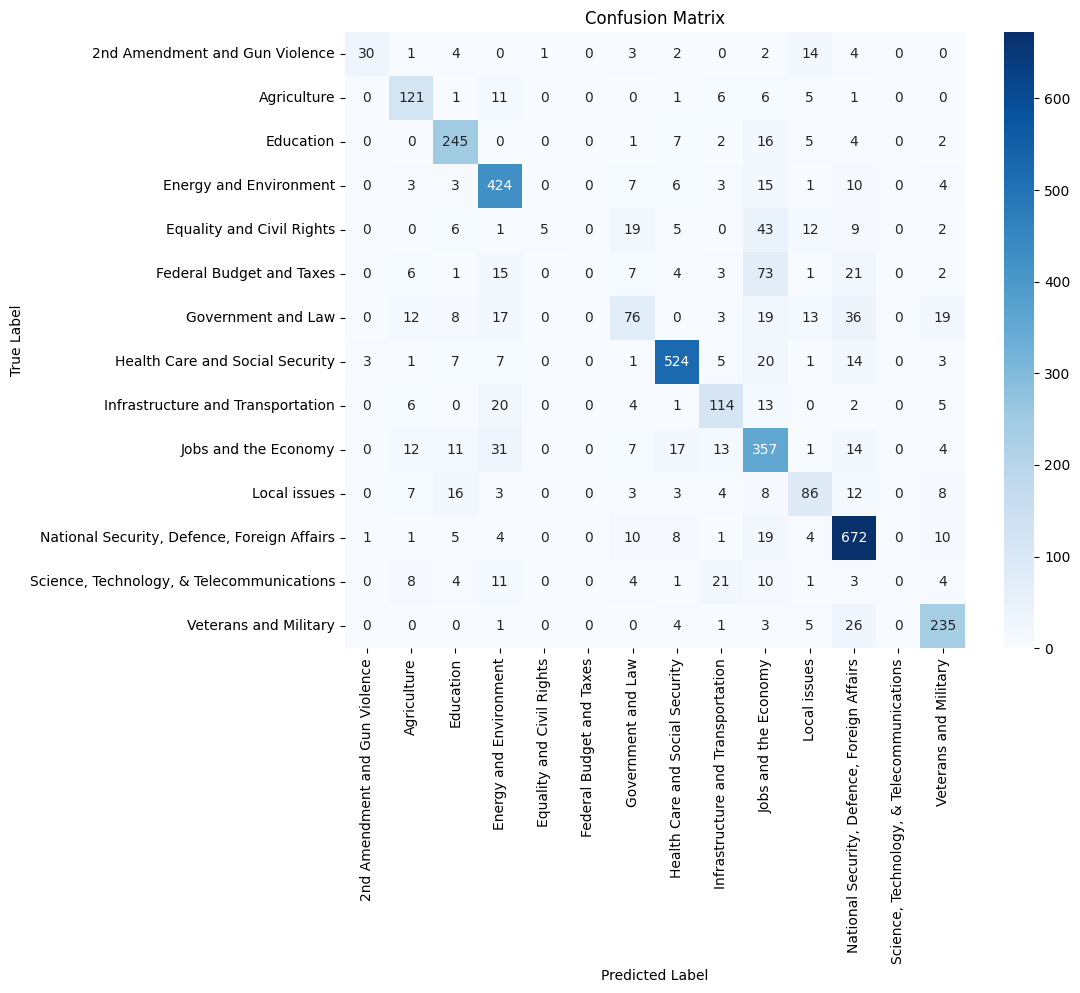

In [ ]:
evaluate(model, val_loader)

In [39]:
class SimpleNN4(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleNN4, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

In [40]:
model = SimpleNN4(input_dim=train_embeddings_tensor.size(1), num_classes=len(df['issue'].unique()))
model.to(device)

optimizer_adam = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-6)
losses, val_losses = train(model, criterion_cros_entr_loss, optimizer_adam, train_loader, val_loader, 500, patience=3, min_delta=2)

Epoch 1, Loss: 1.7146497964859009, Val loss: 1.5024778842926025
Epoch 2, Loss: 1.1274919509887695, Val loss: 0.5538345575332642
Epoch 3, Loss: 0.5961098074913025, Val loss: 0.2822912931442261
Epoch 4, Loss: 0.4910483956336975, Val loss: 0.14783385396003723
Epoch 5, Loss: 0.3095417320728302, Val loss: 0.06635072827339172
Epoch 6, Loss: 0.38611042499542236, Val loss: 0.05205022171139717
Epoch 7, Loss: 0.3381524682044983, Val loss: 0.04657960310578346
Epoch 8, Loss: 0.4565555155277252, Val loss: 0.046807967126369476
Epoch 9, Loss: 0.38190630078315735, Val loss: 0.027353504672646523
Epoch 10, Loss: 0.3639638423919678, Val loss: 0.02629944309592247
Epoch 11, Loss: 0.38167133927345276, Val loss: 0.024861637502908707
Epoch 12, Loss: 0.08372033387422562, Val loss: 0.020479824393987656
Epoch 13, Loss: 0.30827367305755615, Val loss: 0.01252798456698656
Epoch 14, Loss: 0.0741095170378685, Val loss: 0.015516616404056549
Epoch 15, Loss: 0.5090178847312927, Val loss: 0.011286130174994469
Epoch 16, L

                                             precision    recall  f1-score   support

                                  Education       0.87      0.86      0.86       282
                     Energy and Environment       0.92      0.91      0.91       476
            Health Care and Social Security       0.91      0.89      0.90       586
                       Jobs and the Economy       0.81      0.83      0.82       467
National Security, Defence, Foreign Affairs       0.90      0.91      0.91       735
                      Veterans and Military       0.85      0.84      0.85       275

                                   accuracy                           0.88      2821
                                  macro avg       0.88      0.87      0.87      2821
                               weighted avg       0.88      0.88      0.88      2821



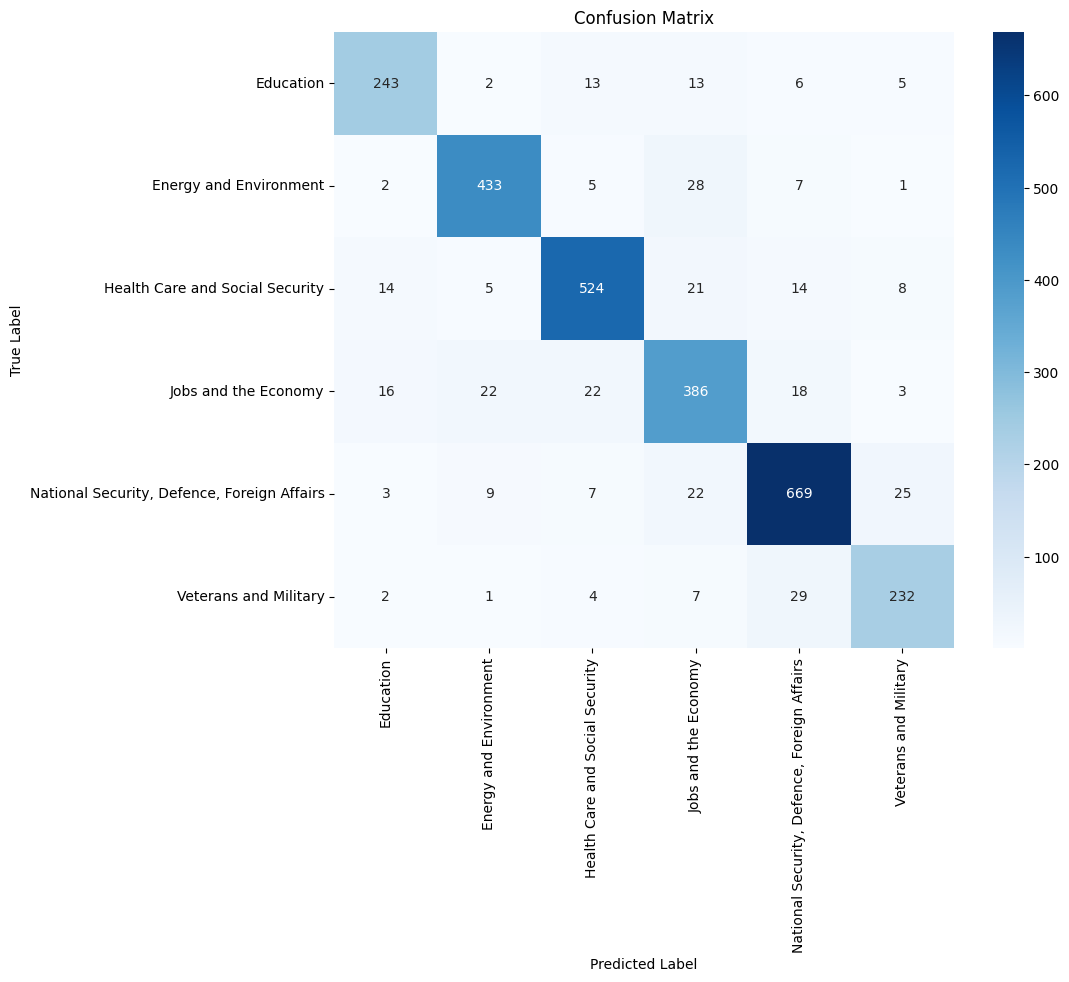

In [41]:
evaluate(model, val_loader)